In [2]:
import planetspy as ps
import planetspy.engines as eng
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [1]:
import planetspy as ps
import planetspy.engines as eng
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

class record:
    loc = []
    def __init__(self, bodies):
        self.loc.append(np.copy(bodies[0][::,0:3]))
    def run(self, simclass):
        self.loc.append(np.copy(simclass.bodies[0][::,0:3]))
        return False

bodies = [
    np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.371*10**6, 5.972*10**24],
              [0, 6.371*10**6 + 400*10**3, 0, -10600, 0, 0, 1, 1000],
              [6.371*10**6 + 385*10**6, 0, 0, 0, 10**3, 0, 1737.5*10**3, 7.35*10**22]
             ])
    , [["Earth", "r-"], ["ISS", "b-"],["Moon", "m-"]]
]

recinst = record(bodies)
sim = ps.Simulate(eng.PP, 100, 10, bodies, bailout = 60*60*24*30, envmod=[recinst])
sim.main_loop()
sim.steps

259200.0

In [16]:
class collisions:
    loc = []
    def __init__(self, bodies):
        self.loc.append(np.copy(simclass.bodies[0][::,0:3]))
    def run(self, simclass):
        self.loc.append(np.copy(simclass.bodies[0][::,0:3]))
        x_dist = np.hstack(simclass.bodies[0][::,0]) - np.vstack(simclass.bodies[0][::,0])
        y_dist = np.hstack(simclass.bodies[0][::,1]) - np.vstack(simclass.bodies[0][::,1])
        z_dist = np.hstack(simclass.bodies[0][::,2]) - np.vstack(simclass.bodies[0][::,2])
        radii_add = np.hstack(simclass.bodies[0][::,6]) + np.vstack(simclass.bodies[0][::,6])
        x_distsq = x_dist**2
        y_distsq = y_dist**2
        z_distsq = z_dist**2
        distsq = (x_distsq + y_distsq + z_distsq)
        dist = np.sqrt(distsq)
        dist = np.where(dist != 0, dist, np.inf)
        distsq = 1/np.where(distsq != 0, distsq, np.inf) 
        dist = np.where(dist >= radii_add , dist, 0)
        simclass.bodies[0] = np.where(dist>= radii_add, simclass.bodies[0], )
        simclass.set_dirty()
        return False

In [37]:

bodies_ = [
    np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1, 100],
              [0, 1, 0, -1, 0, 0, 1, 100],
              [3, 0, 0, 0, 10, 0, 1, 100]
             ])]

x_dist = np.hstack(bodies_[0][::,0]) - np.vstack(bodies_[0][::,0])
y_dist = np.hstack(bodies_[0][::,1]) - np.vstack(bodies_[0][::,1])
z_dist = np.hstack(bodies_[0][::,2]) - np.vstack(bodies_[0][::,2])
radii_add = np.hstack(bodies_[0][::,6]) + np.vstack(bodies_[0][::,6])
print("rad add\n",radii_add)
x_distsq = x_dist**2
y_distsq = y_dist**2
z_distsq = z_dist**2
distsq = (x_distsq + y_distsq + z_distsq)
dist = np.sqrt(distsq)
print('dist initial\n',dist)
dist = np.where(dist != 0, dist, np.inf)
dist = np.where(dist >= radii_add , dist, 0)
collided_bodies = np.where(dist == 0)
coll_bodies = []
for i in range(0, len(collided_bodies[0])//2):
    coll_bodies.append([collided_bodies[0][i], collided_bodies[1][i]])
print('collide\n', coll_bodies)
print('after\n',dist)
print('bod\n',bodies_[0][::,:3])

rad add
 [[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]
dist initial
 [[0.         1.         3.        ]
 [1.         0.         3.16227766]
 [3.         3.16227766 0.        ]]
collide
 [[0, 1]]
after
 [[       inf 0.         3.        ]
 [0.                inf 3.16227766]
 [3.         3.16227766        inf]]
bod
 [[0. 0. 0.]
 [0. 1. 0.]
 [3. 0. 0.]]


<IPython.core.display.Javascript object>


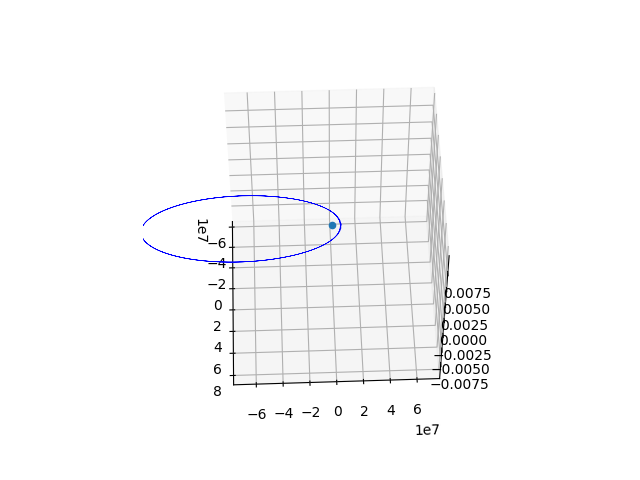

In [34]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


def plot_relative(b):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for j in range(0,len(bodies)+1):
        ax.plot([i[j][0] - i[b][0] for i in recinst.loc], [i[j][1] - i[b][1] for i in recinst.loc], [i[j][2] - i[b][2] for i in recinst.loc], bodies[1][j][1], linewidth = .1)
    ax.scatter(0,0,0,'ro')
    ax.set_aspect("equal")
    plt.show()
    return ax
                                                                                                       
p = plot_relative(0)
#p.set_xlim(-6.371*10**6 + 900*10**3, 6.371*10**6 + 900*10**3)
#p.set_ylim(-6.371*10**6 + 900*10**3, 6.371*10**6 + 900*10**3)

<IPython.core.display.Javascript object>


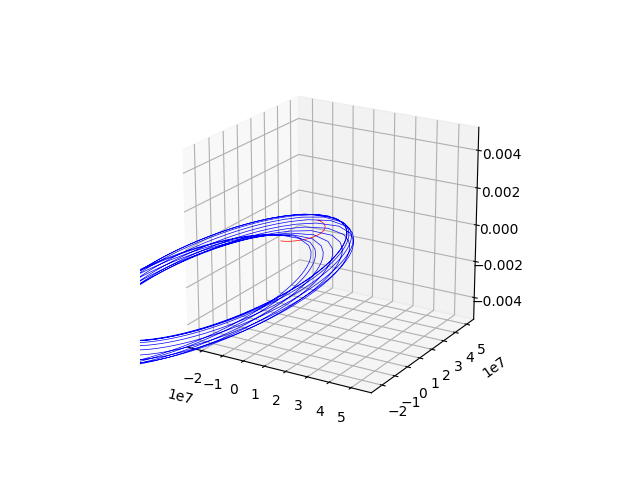

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for j in range(0,len(bodies)+1):
    ax.plot([i[j][0] for i in recinst.loc], [i[j][1] for i in recinst.loc], [i[j][2] for i in recinst.loc], bodies[1][j][1], linewidth = .5)

ax.set_aspect("equal")
plt.show()

<IPython.core.display.Javascript object>


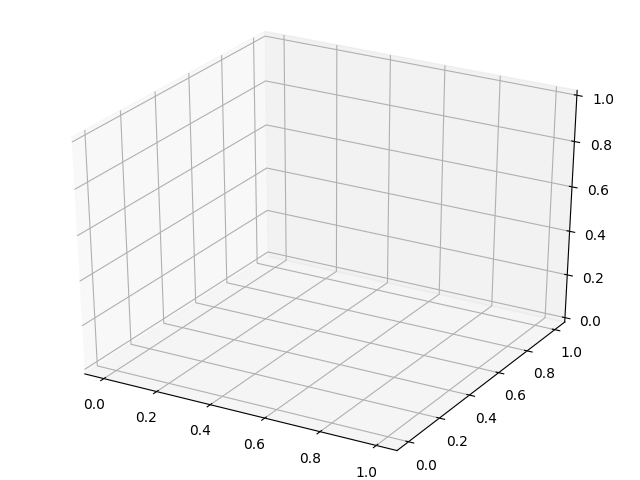

In [67]:
#animation 
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
ax = p3.Axes3D(fig)
particles = ax.plot([],[],[], 'ko')
def animate(i):
    global recinst, ax, fig
                      #all x positions.    , all y positions.    , all z positions
    particles.set_data(recinst.loc[i][::,0], recinst.loc[i][::,1], recinst.loc[i][::,2])
    return particles
ani = animation.FuncAnimation(fig, animate, frames=600, fargs= (bodies, recinst.loc), interval=10, blit=False, init_func=record.__init__)
plt.show()